In [1]:
!pip install split_folders
import splitfolders
splitfolders.ratio("../input/state-farm-distracted-driver-detection/imgs/train", output="./", seed=1337, ratio=(.7, .2, .1), group_prefix=None) # default values

Copying files: 22424 files [02:36, 143.55 files/s]


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight


In [3]:
import os
NUM_CLASSES = len(os.listdir(r'./test'))

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 15692 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# EfficientNet

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.nasnet import NASNetMobile

md = EfficientNetB0(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils.vis_utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
]) 
# summarize layers 
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

2022-10-05 09:40:09.911599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:40:10.006574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:40:10.007348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:40:10.009106: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 4,020,358
Non-trainable params: 42,023
_________________________________________________________________
None


In [5]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=20, callbacks=callback)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-05 09:40:16.031066: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-05 09:40:24.500298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


653/653 [==============================] - 160s 223ms/step - loss: 1.9081 - accuracy: 0.4567 - val_loss: 1.9614 - val_accuracy: 0.4227
Epoch 2/20
653/653 [==============================] - 144s 220ms/step - loss: 0.8399 - accuracy: 0.8565 - val_loss: 0.4042 - val_accuracy: 0.9254
Epoch 3/20
653/653 [==============================] - 145s 222ms/step - loss: 0.3389 - accuracy: 0.9344 - val_loss: 0.1713 - val_accuracy: 0.9617
Epoch 4/20
653/653 [==============================] - 145s 221ms/step - loss: 0.1921 - accuracy: 0.9574 - val_loss: 0.1892 - val_accuracy: 0.9525
Epoch 5/20
653/653 [==============================] - 145s 221ms/step - loss: 0.1239 - accuracy: 0.9743 - val_loss: 0.0917 - val_accuracy: 0.9776
Epoch 6/20
653/653 [==============================] - 143s 219ms/step - loss: 0.0917 - accuracy: 0.9802 - val_loss: 0.0518 - val_accuracy: 0.9859
Epoch 7/20
653/653 [==============================] - 145s 222ms/step - loss: 0.0681 - accuracy: 0.9847 - val_loss: 0.0568 - val_accura

In [6]:
# serialize model to JSON
model_json = model.to_json()
with open("EfficientNetB6.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("EfficientNetB6.h5") 
print("Saved model to disk")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


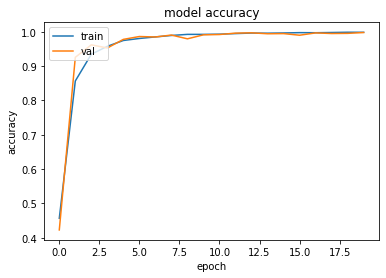

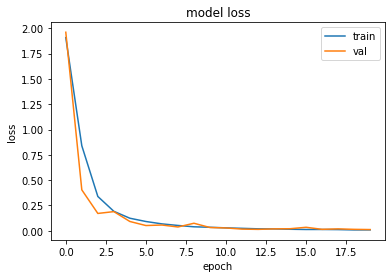

In [7]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Found 2251 images belonging to 10 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


93/93 [==============================] - 13s 129ms/step
               Filename Predictions
0     c0/img_100026.jpg          c0
1       c0/img_1005.jpg          c0
2     c0/img_101175.jpg          c0
3     c0/img_102087.jpg          c0
4      c0/img_10225.jpg          c0
...                 ...         ...
2246   c9/img_96905.jpg          c9
2247   c9/img_97889.jpg          c9
2248   c9/img_98514.jpg          c9
2249    c9/img_9877.jpg          c9
2250   c9/img_99212.jpg          c0

[2251 rows x 2 columns]
2239 12
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       250
           1       1.00      1.00      1.00       228
           2       1.00      1.00      1.00       233
           3       1.00      1.00      1.00       235
           4       1.00      1.00      1.00       233
           5       1.00      0.99      0.99       232
           6       1.00      1.00      1.00       233
           7       1.00      0.99      0.99   

<AxesSubplot:>

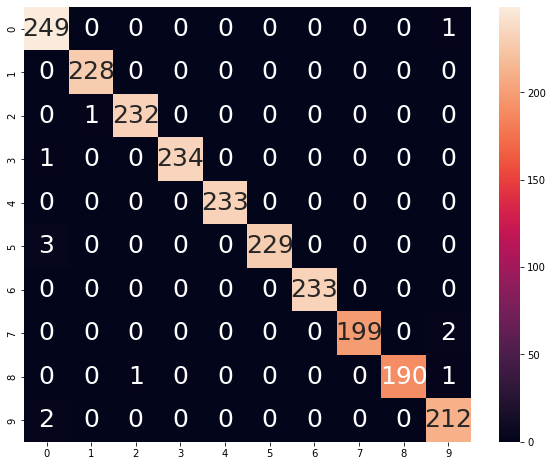

In [8]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')